In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import pickle
import math
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
import matplotlib.gridspec as gridspec
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker
from sklearn import preprocessing

In [2]:
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 10
# fig_size[1] = 10
# plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')

mkt_trend = Table('Market_trend', meta,
                      Column('coin', String, primary_key=True),
                      Column('date', DateTime, primary_key=True),
                      Column('screen', Integer, primary_key=True),
                      Column('dif_current', Float),
                      Column('dif_base', Float),
                      Column('d_dif', Float),
                      Column('theta_current', Float),
                      Column('theta_base', Float),
                      Column('d_theta', Float),
                      Column('long_dif', Float),
                      Column('max_growth', Float),
                      Column('max_loss', Float),
                      Column('max_price', Float),
                      Column('min_price', Float),
                      Column('max_rel', Float),
                      Column('min_rel', Float),
                      Column('log_ret', Float),
                      Column('log_ret_p', Float),
                      Column('log_ret_t_1', Float),
                      Column('histogram', Float),
                      Column('ema_dif', Float),
                      Column('rsi', Float),
                      Column('dif_sma', Float),
                      Column('max_growth_p', Float),
                      Column('obv', Float),
                      Column('strength', Float),
                      Column('vote', Integer)
                      )

tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('volume', Float),
    Column('screen', String, primary_key = True)    
)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [5]:
def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

In [6]:
def scale_df(train, test, scale_columns):
    # #STANDARD SCALER
    scaler = preprocessing.StandardScaler().fit(train[scale_columns])
    train[scale_columns] = scaler.transform(train[scale_columns])
    test[scale_columns] = scaler.transform(test[scale_columns])
    return train, test

FETCH DATA FROM DATABASE AND JOIN TABLES 
MKTTREND - PRICE - MACDS - RSI - SMA

In [7]:
def manipulate_mkt_data():
    df_model = get_mkt_trend()
    df_model.loc[df_model['max_growth'] >= 0.08, 'growth_sign'] = 1
    df_model.loc[df_model['max_growth'] < 0.08, 'growth_sign'] = 0
    dates_ = df_model[['date']]
    shifted_parms = df_model[['coin', 'ema_dif']].shift(1)
    shifted_parms['date'] = dates_
    df_model = pd.merge(df_model, shifted_parms, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    df_model['ema_dif'] = df_model['ema_dif_x']
    df_model['ema_dif_p'] = df_model['ema_dif_y']
    df_model = df_model.drop(['ema_dif_x', 'ema_dif_y'], axis=1)    
    df = df_model.drop(['screen', 'coin'] ,axis=1)
    
    return df
    
df_model = manipulate_mkt_data()
df_model.columns
# df_model['strength_ema'] = df_model.strength.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
# df_model = df_model.dropna()
df_model = df_model.sort_values(['date']).reset_index().drop(['index'], axis=1).dropna()

In [8]:
df_model[['max_growth', 'max_growth_p']].head(n=15)

,max_growth,max_growth_p
5,0.025854,0.080733
6,0.049211,0.066423
7,0.034486,0.030864
8,0.045140,0.015692
9,0.052391,0.000000
10,0.059679,0.036143
11,0.048002,0.025854
12,0.036660,0.049211
13,0.046054,0.034486
14,0.033565,0.045140


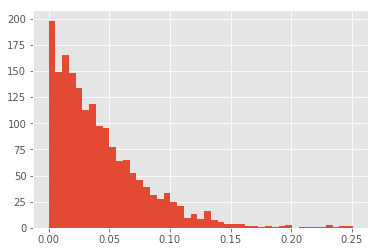

In [9]:
plt.hist(df_model['max_growth'], bins=45)
plt.show()

In [10]:
df = df_model.drop(['date', 'max_price', 'min_price', 'vote', 'max_growth', 'max_loss'], axis=1)

Unbalanced Dataset 0.142697881828


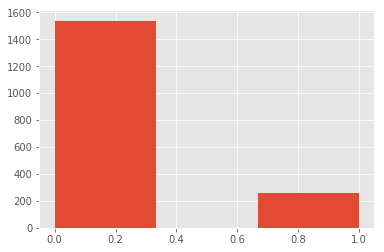

In [11]:
plt.hist(df['growth_sign'], bins=3)
print('Unbalanced Dataset %s' % str(np.sum(df['growth_sign'])/len(df_model)))
plt.show()

In [12]:
drop_columns = ['d_dif', 'strength', 'log_ret', 'log_ret_t_1']

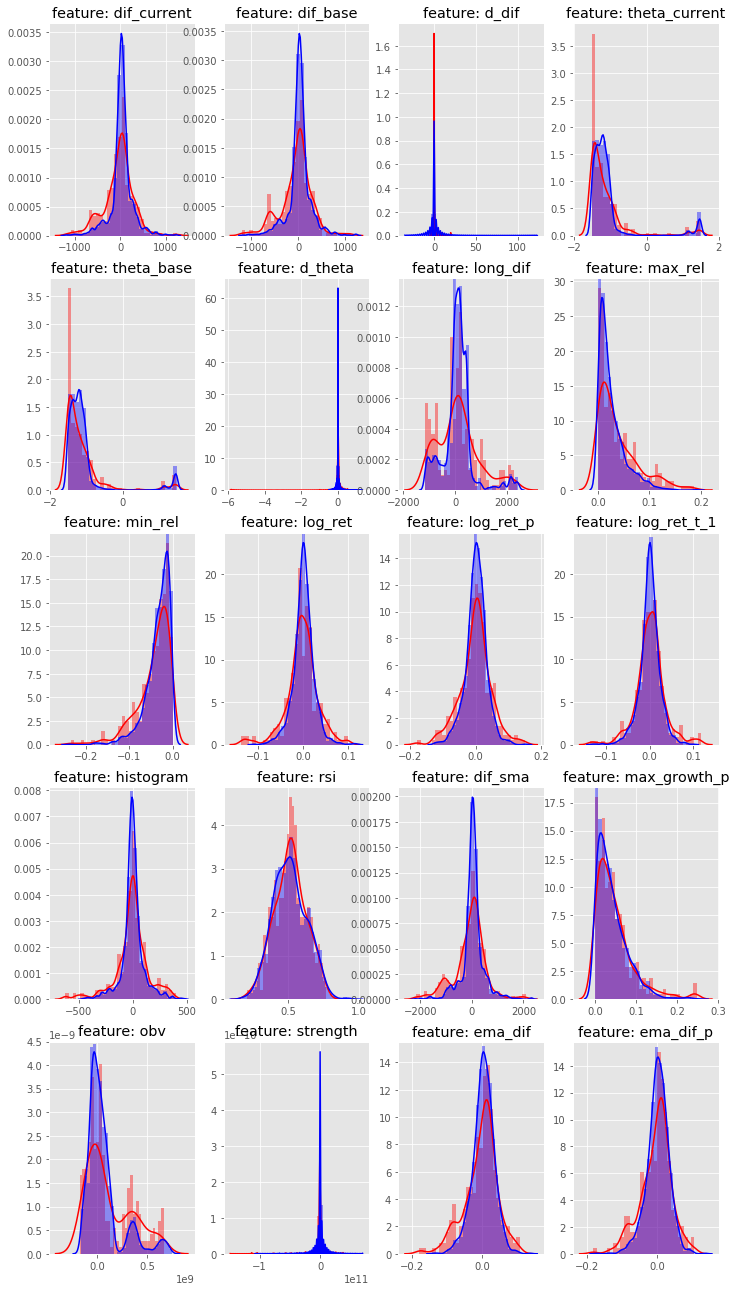

In [13]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, cn in enumerate(df.drop(['growth_sign'], axis=1).columns):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.growth_sign == 1], bins=30, color='red')
    sns.distplot(df[cn][df.growth_sign == 0], bins=30, color = 'blue')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

In [14]:
df = df.drop(drop_columns, axis=1)

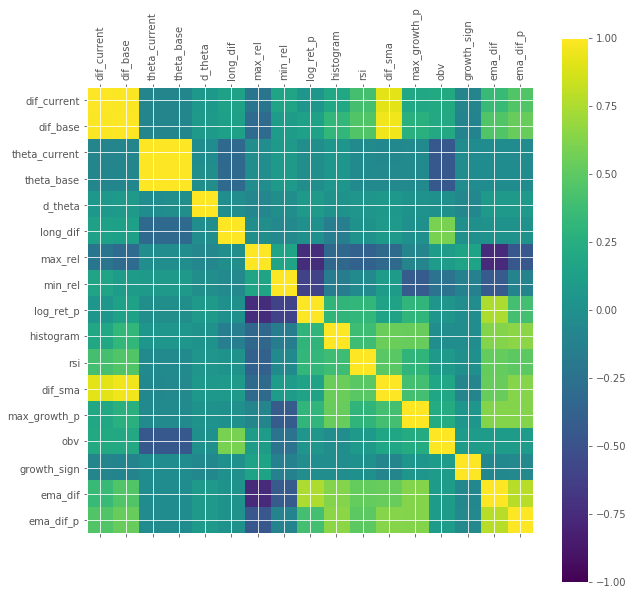

In [15]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

correlations = df.corr()
names = df.columns
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=90)
plt.show()

In [16]:
train = df.iloc[0:math.floor(len(df)*0.75)].copy()
test = df.iloc[math.floor(len(df)*0.75):len(df)].copy()

In [17]:
train.columns

Index(['dif_current', 'dif_base', 'theta_current', 'theta_base', 'd_theta',
       'long_dif', 'max_rel', 'min_rel', 'log_ret_p', 'histogram', 'rsi',
       'dif_sma', 'max_growth_p', 'obv', 'growth_sign', 'ema_dif',
       'ema_dif_p'],
      dtype='object')

In [18]:
scale_columns = df.drop(['growth_sign'], axis=1).columns
scaler = preprocessing.StandardScaler().fit(train[scale_columns])
train[scale_columns] = scaler.transform(train[scale_columns])
test[scale_columns] = scaler.transform(test[scale_columns])

In [19]:
# # #EXAMPLE FOR SCALE NEW ENTRY
# t_transform = scaler.transform(df.loc[0,scale_columns].values.reshape(1,-1))
# print(t_transform)

In [20]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

In [21]:
print('---------------------------------------------------')
X_train, y_train = train.drop(['growth_sign'], axis=1), train.growth_sign.values
X_test, y_test =  test.drop(['growth_sign'], axis=1), test.growth_sign.values
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,y_train)

# RANDOM FOREST
print('Random Forest')
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf':np.arange(1, 8),}
model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='precision')
model.fit(X_train_os, Y_train_os)
Y_predict = model.predict(X_test)

print(model.best_params_)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)
print('---------------------------------------------------')

# EXTRATREE
print('Extra Tree')
X_train, y_train = train.drop(['growth_sign'], axis=1), train.growth_sign.values
X_test, y_test =  test.drop(['growth_sign'], axis=1), test.growth_sign.values
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,y_train)

param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(1,15),
              'min_samples_leaf':np.arange(1, 8),
             'n_estimators': np.arange(1, 5)}

model = GridSearchCV(ExtraTreesClassifier(random_state=42),param_grid, cv=5,scoring='precision')
model.fit(X_train_os,Y_train_os)
Y_predict = model.predict(X_test)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)


---------------------------------------------------
Random Forest
{'max_depth': 1, 'min_samples_leaf': 1}
Precision: 0.17647058823529413
[[278  98]
 [ 52  21]]
---------------------------------------------------
Extra Tree
Precision: nan
[[376   0]
 [ 73   0]]


/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in long_scalars


In [22]:
print('---------------------------------------------------')
print('SVM')

X_train, y_train = train.drop(['growth_sign'], axis=1), train.growth_sign.values
X_test, y_test =  test.drop(['growth_sign'], axis=1), test.growth_sign.values
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train_pca,y_train)

kernels = ['rbf']
Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernels}

model = GridSearchCV(svm.SVC(random_state=42), param_grid, cv=5, scoring='precision')
model.fit(X_train_os,Y_train_os)
Y_predict = model.predict(X_test_pca)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)
print('---------------------------------------------------')

param_grid = {'n_neighbors': np.arange(1, 20)}
knn = KNeighborsClassifier()
model = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
model.fit(X_train_os,Y_train_os)
Y_predict = model.predict(X_test_pca)
cm = confusion_matrix(y_test,Y_predict)
print('Precision: %s' % float(cm[1][1]/(cm[1][1]+cm[0][1])))
print(cm)

---------------------------------------------------
SVM
Precision: 0.17647058823529413
[[208 168]
 [ 37  36]]
---------------------------------------------------
Precision: 0.18652849740932642
[[219 157]
 [ 37  36]]
